In [ ]:
!pip install opendatasets

In [2]:
!pip install tensorflow keras scikit-learn matplotlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os


In [3]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: https://bit.ly/kaggle-creds
Your Kaggle username: yamlapagladeevana
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset


100%|██████████| 2.70G/2.70G [00:26<00:00, 110MB/s] 


In [4]:
import os
import shutil
import uuid

# Input base dir (your messy dataset)
base_dir = "/content/new-plant-diseases-dataset"

# Output clean dataset
output_dir = "/content/dataset"
os.makedirs(output_dir, exist_ok=True)

# Splits to create
splits = ["train", "val", "test"]

for split in splits:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Function to copy class folders into clean structure
def copy_class_folders(src_root, split):
    if not os.path.exists(src_root):
        return
    for class_name in os.listdir(src_root):
        class_path = os.path.join(src_root, class_name)
        if os.path.isdir(class_path):
            dest_path = os.path.join(output_dir, split, class_name)
            os.makedirs(dest_path, exist_ok=True)

            for file in os.listdir(class_path):
                src_file = os.path.join(class_path, file)
                if not os.path.isfile(src_file):
                    continue
                dest_file = os.path.join(dest_path, file)

                # If duplicate filename, rename
                if os.path.exists(dest_file):
                    name, ext = os.path.splitext(file)
                    dest_file = os.path.join(dest_path, f"{name}_{uuid.uuid4().hex[:8]}{ext}")

                shutil.copy(src_file, dest_file)

# -------------------------------
# 1. TRAIN & VAL (from both possible dirs)
# -------------------------------
copy_class_folders(os.path.join(base_dir, "New Plant Diseases Dataset(Augmented)",
                                "New Plant Diseases Dataset(Augmented)", "train"), "train")
copy_class_folders(os.path.join(base_dir, "New Plant Diseases Dataset(Augmented)",
                                "New Plant Diseases Dataset(Augmented)", "valid"), "val")

copy_class_folders(os.path.join(base_dir, "new plant diseases dataset(augmented)",
                                "New Plant Diseases Dataset(Augmented)", "train"), "train")
copy_class_folders(os.path.join(base_dir, "new plant diseases dataset(augmented)",
                                "New Plant Diseases Dataset(Augmented)", "valid"), "val")

# -------------------------------
# 2. TEST (map files into same classes as train/val)
# -------------------------------
test_dir = os.path.join(base_dir, "test", "test")
if os.path.exists(test_dir):
    for file in os.listdir(test_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            # Derive class name from prefix (before first digit or underscore)
            name_part = file.split("1")[0]  # crude split, adjust if needed
            name_part = name_part.rstrip("_-")
            class_name = name_part

            # Create class folder
            class_folder = os.path.join(output_dir, "test", class_name)
            os.makedirs(class_folder, exist_ok=True)

            src_file = os.path.join(test_dir, file)
            dest_file = os.path.join(class_folder, file)

            if os.path.exists(dest_file):
                n, ext = os.path.splitext(file)
                dest_file = os.path.join(class_folder, f"{n}_{uuid.uuid4().hex[:8]}{ext}")

            shutil.copy(src_file, dest_file)

print("✅ Final dataset created at:", output_dir)


✅ Final dataset created at: /content/dataset


In [5]:
DATA_DIR="/content/dataset"
BATCH_SIZE=32
IMG_SIZE=(224,224)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes

Found 140590 images belonging to 38 classes.
Found 35144 images belonging to 38 classes.
Found 33 images belonging to 33 classes.


In [6]:
def build_resnet(num_classes):
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = True  # Fine-tune
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(base.input, out)

def build_efficientnet(num_classes):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base.trainable = True  # Fine-tune
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(base.input, out)

In [7]:
from tensorflow.keras import layers, models, optimizers
resnet_model = build_resnet(num_classes)
efficient_model = build_efficientnet(num_classes)

resnet_model.compile(optimizer=optimizers.Adam(1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

efficient_model.compile(optimizer=optimizers.Adam(1e-4),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]


In [9]:
EPOCHS=1
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

efficient_history = efficient_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4394/4394 ━━━━━━━━━━━━━━━━━━━━ 2326s 515ms/step - accuracy: 0.8968 - loss: 0.3705 - val_accuracy: 0.9709 - val_loss: 0.0860 - learning_rate: 1.0000e-04
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 2041s 445ms/step - accuracy: 0.7925 - loss: 0.7861 - val_accuracy: 0.6771 - val_loss: 1.1810 - learning_rate: 1.0000e-04


In [ ]:
resnet_preds = resnet_model.predict(test_generator)
efficient_preds = efficient_model.predict(test_generator)

ensemble_preds = (resnet_preds + efficient_preds)/2
y_pred = np.argmax(ensemble_preds, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history, model_name="Model"):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Example
plot_training(resnet_history, "ResNet50")
plot_training(efficient_history, "EfficientNetB0")


In [ ]:
import seaborn as sns
import pandas as pd

def plot_class_distribution(generator, title="Class Distribution"):
    classes = list(generator.class_indices.keys())
    counts = [len(os.listdir(os.path.join(generator.directory, c))) for c in classes]
    df = pd.DataFrame({"Class": classes, "Count": counts})

    plt.figure(figsize=(15,5))
    sns.barplot(x="Class", y="Count", data=df)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

# Example
plot_class_distribution(train_generator, "Training Set Class Distribution")
plot_class_distribution(val_generator, "Validation Set Class Distribution")
plot_class_distribution(test_generator, "Test Set Class Distribution")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


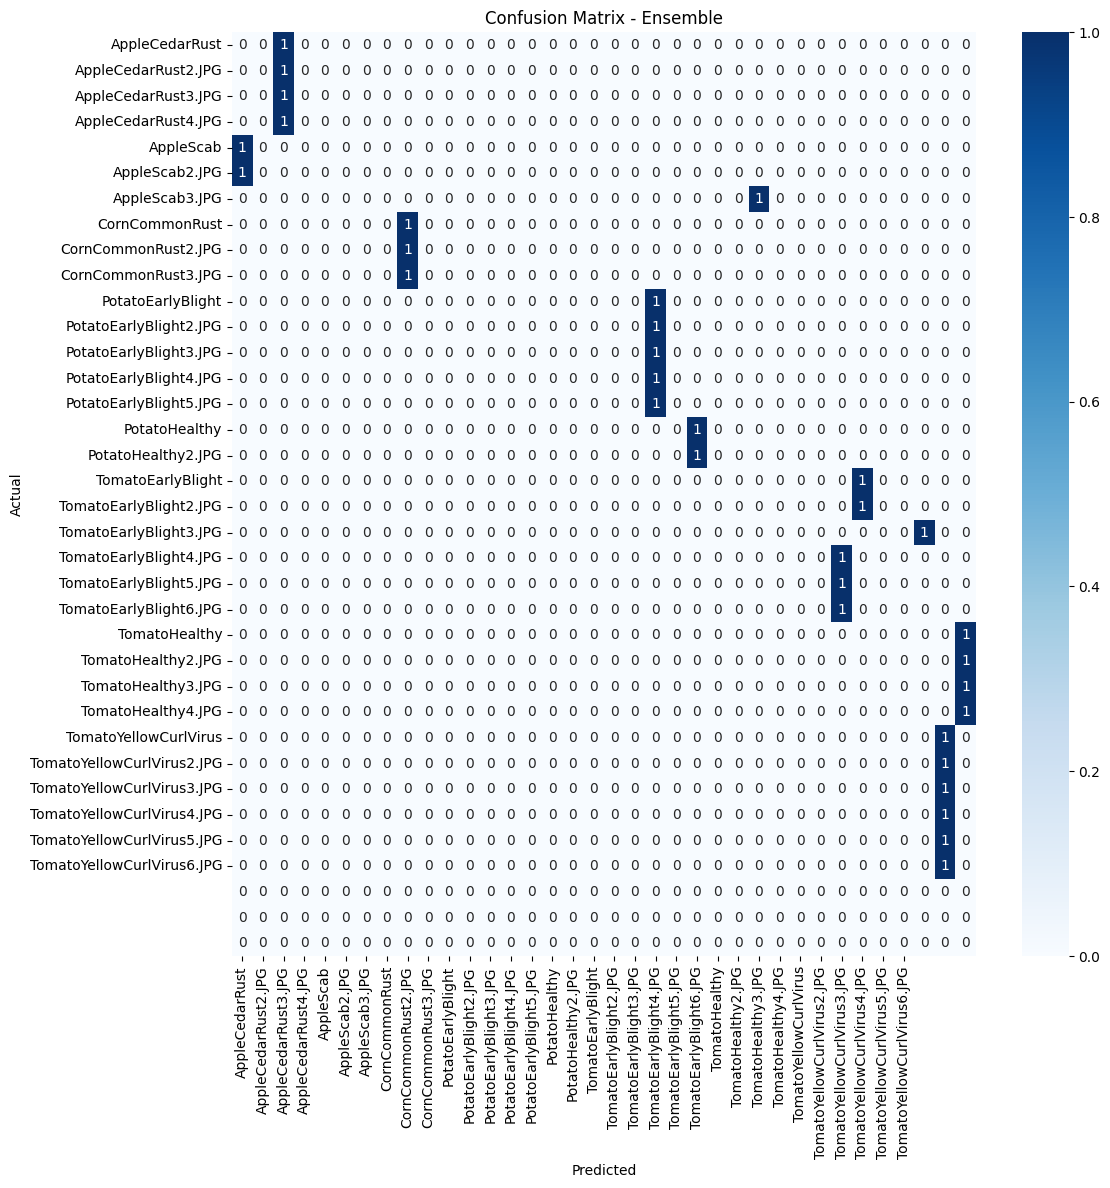

ValueError: Number of classes, 36, does not match size of target_names, 33. Try specifying the labels parameter

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Ensemble predictions
resnet_preds = resnet_model.predict(test_generator)
efficient_preds = efficient_model.predict(test_generator)
ensemble_preds = (resnet_preds + efficient_preds) / 2
y_pred = np.argmax(ensemble_preds, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Ensemble")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
import plotly.express as px

# Class distribution
classes = list(train_generator.class_indices.keys())
counts = [len(os.listdir(os.path.join(train_generator.directory, c))) for c in classes]

fig = px.bar(x=classes, y=counts, title="Training Set Class Distribution")
fig.update_layout(xaxis_tickangle=-45)
fig.show()


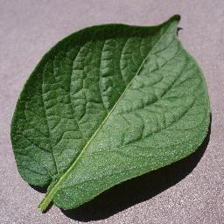

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Actual Class: PotatoHealthy2.JPG | Predicted Class: TomatoEarlyBlight6.JPG



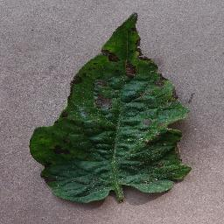

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


IndexError: list index out of range

In [ ]:
import random
from tensorflow.keras.preprocessing import image
from IPython.display import display
from PIL import Image

def display_random_predictions(n=5):
    test_classes = list(test_generator.class_indices.keys())
    test_dir = test_generator.directory
    for _ in range(n):
        cls = random.choice(test_classes)
        img_path = random.choice(os.listdir(os.path.join(test_dir, cls)))
        full_path = os.path.join(test_dir, cls, img_path)

        # Load image
        img = Image.open(full_path).resize((224,224))
        display(img)

        # Preprocess
        img_array = np.expand_dims(np.array(img)/255.0, axis=0)

        # Ensemble prediction
        pred1 = resnet_model.predict(img_array)
        pred2 = efficient_model.predict(img_array)
        pred = (pred1 + pred2)/2
        pred_class = test_classes[np.argmax(pred)]
        print(f"Actual Class: {cls} | Predicted Class: {pred_class}\n")

# Example: display 5 random predictions
display_random_predictions(5)


In [ ]:
import tensorflow as tf
from google.colab import files

# 1. Convert your ensemble model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(ensemble_model)
tflite_model = converter.convert()

# 2. Save it
tflite_filename = "ensemble_model.tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)

# 3. Download it to your computer
files.download(tflite_filename)


In [ ]:
user is in danger ->fill form ->image upload-> current location mapped-> check severity & analyse image ->notify agencies-> resource alloc